In [4]:
import os
from pathlib import Path
import laspy
import geopandas as gpd
from shapely.geometry import Point
import numpy as np
import pandas as pd
import re
import scipy
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import imageio
import seaborn as sns
from datetime import datetime, timedelta
from numpy.polynomial.polynomial import Polynomial
from matplotlib.colors import LinearSegmentedColormap
from PIL import Image
import scipy.io as sio
from scipy.stats import mode
from matplotlib.patches import Patch

In [5]:
cropped_grid = np.load("/Users/cjmack/Documents/Papers/Cliffs/Code/local_grids/cropped_clusters.npz")['data']
cropped_clusters = np.load("/Users/cjmack/Documents/Papers/Cliffs/Code/local_grids/cropped_clusters.npz")['data']

full_grid = np.load("/Users/cjmack/Documents/Papers/Cliffs/Code/local_grids/grid.npz")['data']
grid_files = np.load("/Users/cjmack/Documents/Papers/Cliffs/Code/local_grids/grid_files.npz")['data']

acc_cropped_grid = np.load("/Users/cjmack/Documents/Papers/Cliffs/Code/local_grids/acc_cropped_grid.npz")['data']
acc_cropped_clusters = np.load("/Users/cjmack/Documents/Papers/Cliffs/Code/local_grids/acc_cropped_clusters.npz")['data']

acc_grid_files = np.load("/Users/cjmack/Documents/Papers/Cliffs/Code/local_grids/acc_grid_files.npz")['data']
acc_cluster_files = np.load("/Users/cjmack/Documents/Papers/Cliffs/Code/local_grids/acc_cluster_files.npz")['data']

In [6]:
# use cropped grid and clusters to find mean retreat per year for each year 
# where retreat is volume / section length (2250 m) / height (18 m)


def plot_retreat(grid_3d, grid_files, res=0.01, section_length=2250, avg_height=18):
    """
    Computes and plots the annual retreat based on erosion data.

    The retreat for a given year is defined as:
        retreat = (total annual erosion volume) / (section_length * avg_height)
    where:
      - The erosion volume at each time step is computed from grid_3d (forced to be negative).
      - The absolute (positive) value of the total annual erosion is used.
      - section_length (default 2250 m) and avg_height (default 18 m) are used to convert volume to a linear retreat.

    Parameters:
        grid_3d (numpy.ndarray): 3D erosion grid data of shape (n_time, alongshore_length, depth).
        grid_files (list of str): List of filenames for the erosion grid data.
                                  Each filename is assumed to contain an 8-digit date,
                                  where the fourth occurrence is used as the date.
        res (float): Resolution factor to multiply the grid data (default 0.01).
        section_length (float): Length of the section in meters (default 2250 m).
        avg_height (float): Average height in meters (default 18 m).
    """
    import re
    from datetime import datetime
    import numpy as np
    import matplotlib.pyplot as plt

    # Regular expression to extract dates (assuming filenames contain an 8-digit date, e.g., YYYYMMDD)
    date_pattern = re.compile(r"(\d{8})")
    
    # Extract dates from grid_files
    dates = []
    for file in grid_files:
        match = date_pattern.findall(file)
        if match and len(match) >= 4:
            # Use the fourth occurrence as the date.
            date_str = match[3]
            dates.append(datetime.strptime(date_str, "%Y%m%d"))
        else:
            dates.append(None)
    
    # Compute erosion volumes per time step.
    # Force volumes to be negative.
    erosion_volumes = -np.abs(np.nansum(grid_3d * res, axis=(1, 2)))
    
    # Aggregate total annual erosion (summing the volumes for each year)
    annual_erosion = {}
    for date, vol in zip(dates, erosion_volumes):
        if date is not None:
            year = date.year
            annual_erosion[year] = annual_erosion.get(year, 0) + vol

    # Calculate annual retreat.
    # Multiply by -1 since erosion_volumes are negative, then divide by (section_length * avg_height).
    annual_retreat = {year: (-vol) / (section_length * avg_height)
                      for year, vol in annual_erosion.items()}
    
    # Sort years and corresponding retreat values.
    years_sorted = sorted(annual_retreat.keys())
    retreat_values = [annual_retreat[year] for year in years_sorted]
    
    # Plot the annual retreat as scatter points.
    plt.figure(figsize=(8, 4))
    plt.scatter(years_sorted, retreat_values, color='blue', s=100, zorder=3)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Retreat (m)', fontsize=12)
    plt.title('Annual Retreat', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()



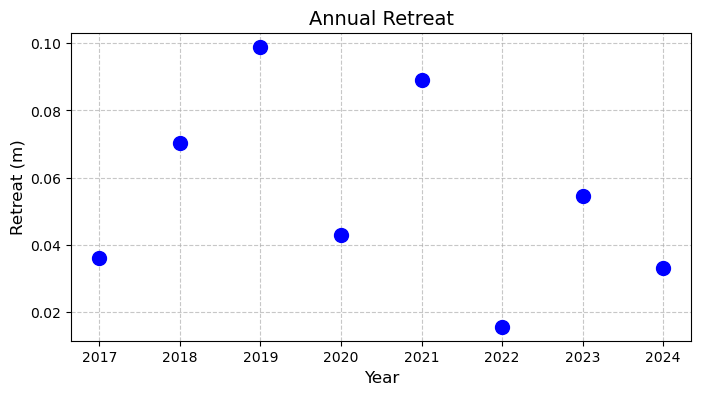

In [7]:
plot_retreat(cropped_grid, grid_files, res=0.01, section_length=2250, avg_height=18)